In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from geopy.geocoders import Nominatim

import pycountry_convert as pc

import os

In [3]:
file_name = os.path.join("archive","earthquake_data.csv")
file_name_clean = os.path.join("archive","earthquake_data_clean.csv")

file_name_filtered_2022 = os.path.join("archive","earthquake_data_clean_filtered-2022.csv")

print("file_name:", file_name)
print("file_name_clean:", file_name_clean)

file_name: earthquake_data.csv
file_name_clean: earthquake_data_clean.csv


In [4]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

# Use a fallback for the continent if it's not present
continent_lookup = {
    "Africa": "Africa",
    "Asia": "Asia",
    "Europe": "Europe",
    "North America": "North America",
    "South America": "South America",
    "Oceania": "Oceania",
    "Antarctica": "Antarctica",
}

co_cn_map = {
    "Antarctica": "Antarctica",
    "United Kingdom of Great Britain and Northern Ireland (the)": "Europe",
    "South Georgia and the South Sandwich Islands": "South America",
    "Chile": "South America",
    "Mexico": "North America",
    "United States of America": "North America"
}

In [5]:
def get_cn_continent(country_name_raw):
    country_name = country_name_raw.split("(")[0].strip().lower()
    country_name = country_name[0].upper() + country_name[1:]
    country_name_words = country_name.split()
    if len(country_name_words) > 1:
        country_name = ""
        for i, word in enumerate(country_name_words):
            if word != "of":
                current_word = word[0].upper() + word[1:]
                if i != 0:
                    country_name += " " + current_word
                else:
                    country_name += current_word
            else:
                country_name += " of"  
    if country_name in ["Usa", "Usa Territory"]:
        country_name = "United States of America"
    country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    alpha3_code = pc.country_name_to_country_alpha3(country_name, cn_name_format="default")
    return alpha3_code, continents[continent_name]

In [6]:
class Dataset():
    def __init__(self, file_name, file_name_clean):
        """
        Initializes the Dataset class.

        Parameters:
        - file_name (str): Path to the raw dataset file.
        - file_name_clean (str): Path to the cleaned dataset file.
        """
        self.file_name = file_name
        self.file_name_clean = file_name_clean
        self.data = None

    def post_process(self, df):
        """
        Add a 'year' column to the DataFrame based on the 'date_time' column.

        Parameters:
        - df (pd.DataFrame): The DataFrame to process.
        """
        df['year'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M').dt.year

    def load_data_raw(self):
        """
        Load and clean the raw dataset.

        Returns:
        - pd.DataFrame: The cleaned dataset.
        """
        df_raw = pd.read_csv(self.file_name)

        print(df_raw.describe())
        print(df_raw.shape)
        print(df_raw.isnull().sum())

        drop_indices = []
        n = len(df_raw)

        for i, row in enumerate(df_raw.itertuples()):
            country = row.country
            continent = row.continent

            lookup_country, lookup_continent = None, None
            if self.is_empty(row.country) or self.is_empty(row.continent):
                print(f"{country}, {continent}")
                lookup_country, lookup_continent = self.lookup_country_and_continent(country, row.latitude, row.longitude)
                print(f"lookup ({row.latitude}, {row.longitude}) = {lookup_country}, {lookup_continent}")
                if (not self.is_empty(country) and self.is_empty(lookup_country)) or (not self.is_empty(continent) and self.is_empty(lookup_continent)):
                    print(f"*** Fix: {country} | {lookup_country}, {continent} | {lookup_continent}")

            if self.is_empty(country):
                country = lookup_country

            if self.is_empty(continent):
                continent = lookup_continent

            if self.is_empty(country) or self.is_empty(continent):
                drop_indices.append(i)

            print(f"{i} of {n} completed.")

        print(f"{len(drop_indices)} samples will be dropped.")
        df = df_raw.drop(drop_indices)

        self.post_process(df)

        self.reindex_df(df)
        df.drop(list(np.where(np.logical_or(pd.isna(df['country']), pd.isna(df['continent'])) == True)[0]), inplace=True)
        self.reindex_df(df)

        df.to_csv(self.file_name_clean, index=False)

        self.data = df
        return df

    def load_data_clean(self):
        """
        Load the cleaned dataset.

        Returns:
        - pd.DataFrame: The cleaned dataset.
        """
        df = pd.read_csv(self.file_name_clean)

        if "Unnamed: 0" in df.columns:
            df.drop("Unnamed: 0", axis=1, inplace=True)

        self.post_process(df)
        self.data = df
        return df
    
    def load_data(self):
        """
        Load data based on availability. If a clean data file exists, it loads clean data; otherwise, it processes raw data.

        Returns:
            pd.DataFrame: The loaded data, either clean or raw.
        """        
        df = None
        if os.path.exists(file_name_clean):
            print("Loading clean data...")
            df = self.load_data_clean()
            print("Loading finished.")
        else:
            print("Loading raw data...")
            df = self.load_data_raw()
            print("Loading finished.")
        return df

    @staticmethod
    def is_empty(value):
        """
        Check if a value is empty or None.

        Parameters:
        - value: The value to check.

        Returns:
        - bool: True if the value is empty, False otherwise.
        """
        return pd.isna(value) or value == "" or value == None

    @staticmethod
    def get_continent(country_name_raw):
        """
        Retrieve the continent name for a given country name.

        Args:
            country_name_raw (str): The raw name of the country.

        Returns:
            str: The continent name corresponding to the given country.
        """
        return get_cn_continent(country_name_raw)[1]

    @staticmethod
    def lookup_country_and_continent(country, lat, lon):    
        """
        Lookup the country and continent based on the provided country name, latitude, and longitude.

        Args:
            country (str): The initial country name (may be raw or unverified).
            lat (float): The latitude of the location.
            lon (float): The longitude of the location.

        Returns:
            tuple: A tuple containing the verified country name (or 'Unknown') and the corresponding continent name.

        Notes:
            - If the country is already mapped in the `co_cn_map`, it retrieves the corresponding continent.
            - Otherwise, it uses geopy's `Nominatim` to reverse-geocode the latitude and longitude to get the country and continent.
            - The function handles exceptions gracefully and returns (None, None) if an error occurs.
        """
        if country in co_cn_map:
            return country, co_cn_map[country]

        geolocator = Nominatim(user_agent="geo_locator")
        try:
            location = geolocator.reverse((lat, lon), exactly_one=True, language="en")
            if location:
                address = location.raw.get("address", {})
                country = address.get("country", "Unknown")
                continent = address.get("continent", "Unknown")  # Not all geopy data provides continent directly                       

                if not continent:
                    continent_code = address.get("ISO3166-1:alpha3")[:2]
                    continent = continent_lookup.get(continent_code,"Unknown")                

                return country, get_continent(country)
            else:
                return None, None
        except Exception as e:
            print(f"Error: {e}")
            return None, None

    @staticmethod
    def reindex_df(df):
        """
        Reindex the DataFrame.

        Parameters:
        - df (pd.DataFrame): The DataFrame to reindex.
        """        
        df.reset_index(inplace = True)
        df.drop("index", axis = 1, inplace = True)


In [7]:
dataset = Dataset(file_name, file_name_clean)
df = dataset.load_data()    
df.head()

Loading clean data...
Loading finished.


title  magnitude         date_time  \
0  M 7.0 - 18 km SW of Malango, Solomon Islands        7.0  22-11-2022 02:03   
1                                      M 7.0 -         7.0  12-11-2022 07:09   
2        M 6.8 - 55 km SSW of Aguililla, Mexico        6.8  22-09-2022 06:16   
3        M 7.6 - 35 km SSW of Aguililla, Mexico        7.6  19-09-2022 18:05   
4             M 6.9 - 90 km E of Yujing, Taiwan        6.9  18-09-2022 06:44   

   cdi  mmi   alert  tsunami   sig net  nst   dmin   gap magType    depth  \
0    8    7   green        1   768  us  117  0.509  17.0     mww   14.000   
1    3    3   green        1   755  us  147  3.125  18.0     mww  579.000   
2    8    7  yellow        1  1179  us  175  2.137  92.0     mww   20.000   
3    9    8  yellow        1  1799  us  271  1.153  69.0     mww   26.943   
4    9    9  yellow        1   887  us  215  0.401  34.0     mww   10.000   

   latitude  longitude                  location      continent  \
0   -9.7963    159.596  Malango, Solomon Islands        Oceania   
1  -20.0508   -178.346                       NaN        Oceania   
2   18.3300   -102.913         Aguililla, Mexico  North America   
3   18.3667   -103.252         Aguililla, Mexico  North America   
4   23.1444    121.307            Yujing, Taiwan           Asia   

           country  year  
0  Solomon Islands  2022  
1             Fiji  2022  
2           Mexico  2022  
3           Mexico  2022  
4           Taiwan  2022

In [8]:
_nrows = 1
_ncols = 3

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

COUNTRIES = ["Mexico", "Ecuador", "Japan"]

plt.suptitle(f"Average Magnitude of Countries", fontweight = "bold")

for i, COUNTRY in enumerate(COUNTRIES):
    
    plt.subplot(_nrows, _ncols, i + 1)
    
    plt.title(COUNTRY.capitalize())
    
    df_country = df[df.country == COUNTRY]

    df_country_filtered = df_country.loc[:, ["magnitude", "year"]].dropna()
    df_country_filtered = df_country_filtered[df_country_filtered.year > 2000]
    df_country_filtered_mean = df_country_filtered.groupby("year").mean()
    
    years = [int(year) for year in df_country_filtered_mean.index]
    
    magnitude_means = [int(v) for v in df_country_filtered_mean.values]
    
    if i == 0:
        plt.ylabel("Average Magnitude", fontweight = "bold")
    plt.xlabel("Year", fontweight = "bold")
    
    plt.xticks(range(min(years), max(years) + 3, 3))
        
    plt.bar(years, magnitude_means)
    
plt.show()

In [9]:
df_magnitude = list(np.where(pd.notnull(df.loc[:, "magnitude"]).values == True)[0])
df.iloc[df_magnitude]
df_magnitude_filtered = df.loc[df_magnitude, ["country", 
                                              "magnitude", 
                                              "depth",                                              
                                              "year"]]
df_magnitude_filtered = df_magnitude_filtered.fillna(0)

countries = set(df_magnitude_filtered.country)
years = set(df_magnitude_filtered.year)


df_magnitude_filtered_groupby_country = df_magnitude_filtered.groupby("country")

years_countries = dict()

for country in countries:
    country_years = list(df_magnitude_filtered_groupby_country.get_group(country).year)
    for year in years:            
        if year not in years_countries:
            years_countries[year] = []
        if year in country_years:
            years_countries[year].append(country)

df_magnitude_filtered_2022 = df_magnitude_filtered[df_magnitude_filtered.year == 2022]

with open(file_name_filtered_2022, mode="w") as f:
    f.write('"country","continent","year","value","depth","mag_over_dep","iso_alpha"\n')
    
countries_magnitude = dict()

with open(file_name_filtered_2022, mode="a+") as f:
    for group in df_magnitude_filtered_2022.groupby("country"):
        country_name = group[0]
        average_magnitude = np.average(group[1].magnitude.values)    
        average_depth = np.average(group[1].depth.values)    
        f.write(f'"{country_name}","{get_cn_continent(country_name)[1]}",2022,{average_magnitude},{average_depth},{average_magnitude/average_depth},"{get_cn_continent(country_name)[0]}"\n')
        
data = pd.read_csv(file_name_filtered_2022)

fig = px.choropleth(data, locations='iso_alpha', color='value', hover_name='country',
                    projection='natural earth', animation_frame='year',
                    title='Average magnitude by country in 2022')

fig.show()

fig = px.choropleth(data, locations='iso_alpha', color='depth', hover_name='country',
                    projection='natural earth', animation_frame='year',
                    title='Average depth by country in 2022')

fig.show()

fig = px.choropleth(data, locations='iso_alpha', color='mag_over_dep', hover_name='country',
                    projection='natural earth', animation_frame='year',
                    title='Average magnitude over depth by country in 2022')

fig.show()

In [9]:
target_numric_columns = ["magnitude" , "cdi", "mmi", "sig", "net", "nst", "dmin", "gap", "depth"]

corr_matrix = df.loc[:,target_numric_columns].corr(numeric_only = True)

plt.figure(figsize=(10, 6))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap of Earthquake Features")

plt.show()

In [10]:
plt.figure(figsize=(8, 6))

plt.scatter(df['magnitude'], df['depth'], alpha=0.7, c='blue', edgecolor='k')

plt.title('Scatter Plot of Magnitude vs Depth')
plt.xlabel('Magnitude')
plt.ylabel('Depth')

plt.grid(True)

plt.show()

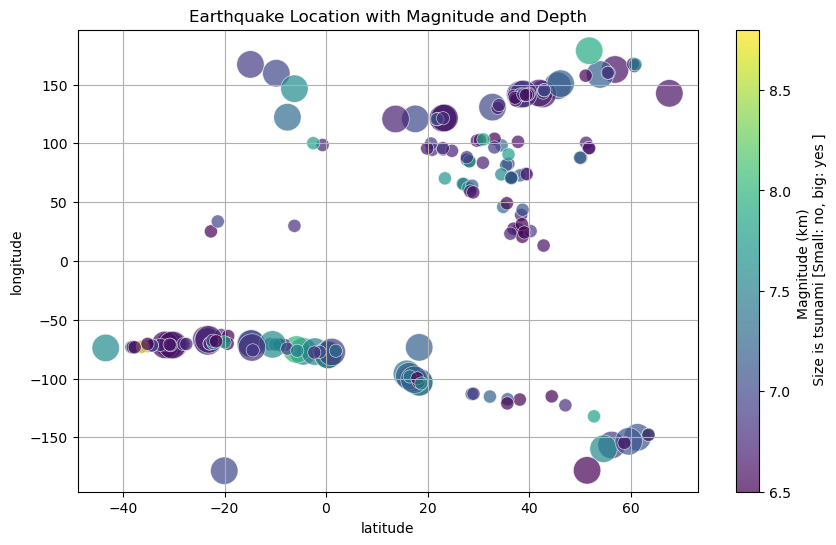

In [11]:
# Select relevant columns: 'latitude', 'longitude', 'magnitude', and 'depth'
data = df[['tsunami', 'latitude', 'longitude', 'magnitude', 'depth']]

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))

# Plot with latitude and longitude on axes, depth as color, magnitude as size
scatter = plt.scatter(
    data['latitude'], data['longitude'], 
    c=data['magnitude'], s=(data['tsunami']+0.3) * 300,  # scale size for visibility
    cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5
)

# Customize plot
plt.title('Earthquake Location with Magnitude and Depth')
plt.xlabel('latitude')
plt.ylabel('longitude')

# Add color bar for depth
plt.colorbar(scatter, label='Magnitude (km) \n Size is tsunami [Small: no, big: yes ]')

# Show plot
plt.grid(True)
plt.show()